In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')
import pandas_datareader as web
import datetime as dt 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
crypto_currency = 'BNB'
against_currency ='USD'
start = dt.datetime(2021,1,1)
end = dt.datetime.now()
df = pd.read_csv('Binance_BTCUSDT_d1.csv')
target_col = 'close'
df = df.iloc[::-1]

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df_month = df.resample('M').mean()
# df.sort_index(inplace=True)

Checking stationarity of the given data, using ADFuller test, 
p must be less than 0.05 to discard the null hypothesis that our series is non-stationary

In [6]:
seasonal_decompose(df_month.close, period=1).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_month.close)[1])
plt.show()

TypeError: ignored

p greater than 0.05, that is our series is stationary

In [7]:
# Box-Cox Transformations
df_month['close_box'], lmbda = stats.boxcox(df_month.close)
print("Dickey–Fuller test: p=%f" % adfuller(df_month.close_box)[1])

Dickey–Fuller test: p=0.220253


Using Differencing method to make our non-stationary series stationary

In [8]:
# df_month['close_diff']=df_month.close_box.diff(periods=0)
df_month.close_diff[1:]

AttributeError: ignored

p less than 0.05, now our series is stationary, and we can use ARIMA model.
ARIMA works better on stationary.

In [ ]:
seasonal_decompose(df_month.close_box, period=1).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_month.close_box)[1])

In [12]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     |████████████████████████████████| 1.5MB 12.2MB/s 
     |████████████████████████████████| 9.5MB 52.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [13]:
arima_model = auto_arima(df_month.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True).fit(df_month.close)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=869.028, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=853.244, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=852.981, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=870.180, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=853.258, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=854.264, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=855.328, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=852.073, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=851.522, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=851.379, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=850.649, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=851.214, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=849.510, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=851.410, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=852.0

In [14]:
pred = pd.Series(arima_model.predict(n_periods=20))
pred.columns = ['close']

In [16]:
print(df_month.close.tail())
pred.head()

date
2021-01-31    34715.923548
2021-02-28    46269.023214
2021-03-31    54836.615806
2021-04-30    57064.064000
2021-05-31    48009.249259
Freq: M, Name: close, dtype: float64


0    36371.361670
1    24800.599433
2    15439.221706
3     9617.554597
4     7758.032217
dtype: float64

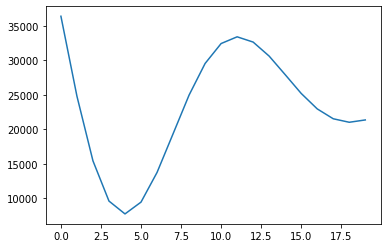

In [17]:
plt.plot(pred)

In [21]:
!pip install pyplot

ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


In [24]:
import fbprophet
from matplotlib import pyplot
from fbprophet import Prophet

In [41]:
df1 = df.drop(['unix', 'symbol','open','high','low','Volume BTC', 'Volume USDT', 'tradecount'],axis=1)
df1.columns =['ds','y']
df1['ds'] = pd.to_datetime(df1['ds'])

In [62]:
model = Prophet()
model.fit(df1[1200:])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
future = list()
date = datetime(2021,2,27)
for i in range(1, 30):
  date += timedelta(days=1)
  future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

In [67]:
forecast = model.predict(future)

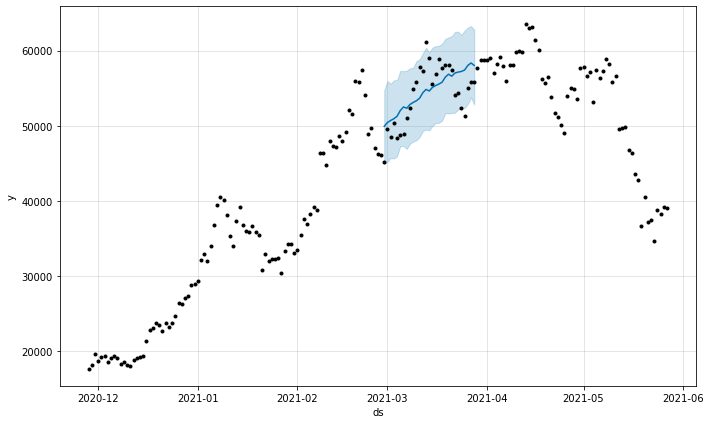

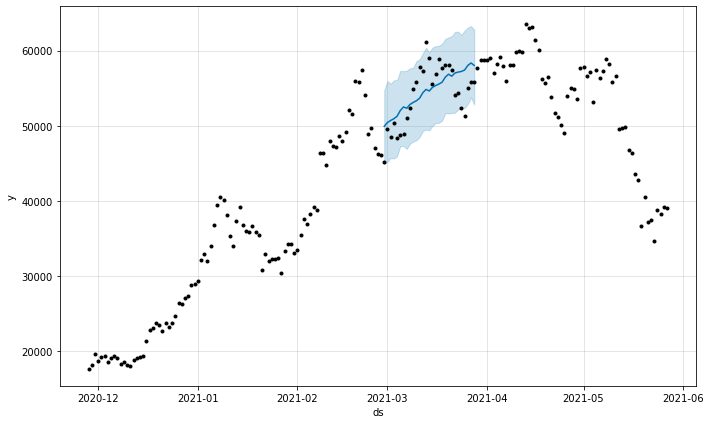

In [68]:
model.plot(forecast)

In [58]:
len(df)

1381